# 🌿 Plant Disease Detection using CNN (Keras)
This notebook demonstrates how to train a Convolutional Neural Network (CNN) to classify plant leaves as healthy or diseased using the PlantVillage dataset.

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

## 🔄 Load and preprocess the dataset
- Ensure your dataset is in `plant_dataset/` directory.
- The folder should have subfolders for each class (e.g., `Tomato___Bacterial_spot`, `Tomato___Healthy`).

In [3]:
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = datagen.flow_from_directory(
    'plant_dataset/',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    'plant_dataset/',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


## 🧠 Build the CNN Model

In [5]:
# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

In [6]:
# Build the full model
inputs = Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

In [8]:
# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 2277199 (8.69 MB)
Trainable params: 19215 (75.0

In [9]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

## 🚀 Train the Model

In [ ]:
# Train
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15


 98/517 [====>.........................] - ETA: 12:23 - loss: 1.8555 - accuracy: 0.4263

## 📈 Plot Training History

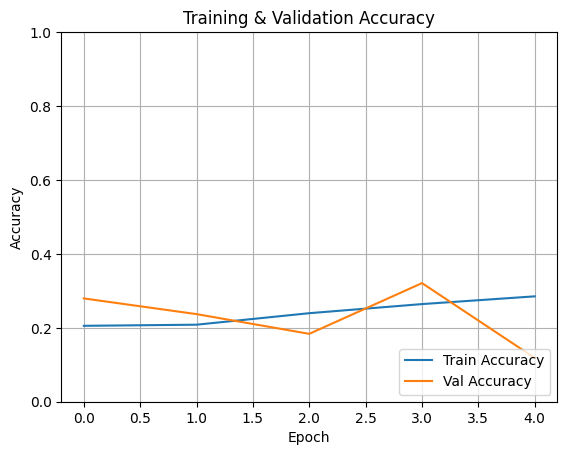

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy (MobileNetV2)')
plt.grid(True)
plt.show()

## 💾 Save and Export the Model to TensorFlow.js

In [ ]:
# Save model
model.save('mobilenetv2_plant_model')
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'model_tfjs/')